In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
# Force a garbage collection process
gc.collect()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_auc_score, accuracy_score, classification_report

In [3]:
df = pd.read_csv("data_pre.csv")

In [4]:
df.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDate,mismatched_country,mismatched_cvv,time_diff
0,100737756,250,250.00,2016-01-07 09:37:09,1.86,1st Sandwitch Bar #396252,US,US,05,01,...,4317,PURCHASE,0.00,True,False,False,2016-01-07,True,True,<Unknown>
1,100737756,250,248.14,2016-01-08 16:20:51,193.25,Downtown Pub,US,US,02,01,...,4317,PURCHASE,1.86,True,False,False,2016-01-08,True,True,1 days 06:43:42
2,100737756,250,54.89,2016-01-10 21:02:12,650.62,Franks Pub #87366,US,US,09,01,...,4317,PURCHASE,195.11,True,False,False,2016-01-10,True,True,2 days 04:41:21
3,100737756,250,-319.58,2016-01-12 17:46:25,0.00,Downtown Sandwitch Bar,US,US,02,01,...,4317,ADDRESS_VERIFICATION,569.58,False,False,False,2016-01-12,True,True,1 days 20:44:13
4,100737756,250,159.70,2016-01-13 21:29:12,104.11,Franks Pub #87366,US,US,05,01,...,4317,PURCHASE,90.30,True,False,False,2016-01-13,True,True,1 days 03:42:47


In [5]:
cols_to_exclude = ["cardCVV", "enteredCVV", "currentExpDate", "accountOpenDate"]
df.drop(cols_to_exclude, axis=1, inplace=True)

In [6]:
features = [
    'customerId',
    'creditLimit',
    'availableMoney',
    'transactionDateTime',
    'transactionAmount',
    'merchantName',
    'acqCountry',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'merchantCategoryCode',
    'dateOfLastAddressChange',
    'cardLast4Digits',
    'transactionType',
    'currentBalance',
    'cardPresent',
    'expirationDateKeyInMatch',
    'transactionDate',
    'mismatched_country',
    'mismatched_cvv',
    'time_diff'
]

cat_features = [
    'customerId',
    'creditLimit',
    'merchantName',
    'acqCountry',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'merchantCategoryCode',
    'cardLast4Digits',
    'transactionType',
    'cardPresent',
    'expirationDateKeyInMatch',
    'mismatched_country',
    'mismatched_cvv',
]


In [7]:
time_columns = ['transactionDateTime', 'dateOfLastAddressChange', 'transactionDate']

for column in time_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df[column] = df[column].astype('int64') / 10**9  # Convert to Unix timestamp in seconds

df['time_diff'] = pd.to_timedelta(df['time_diff'], errors='coerce').dt.total_seconds()


In [8]:
df.to_csv("df_for_model.csv", index=False)

In [9]:
# Force a garbage collection process
gc.collect()

21

In [10]:
test_size = int(df.shape[0] * 0.1)
tscv = TimeSeriesSplit(test_size=test_size)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}  size={len(train_index)}")
    print(f"  Test:  index={test_index}  size={len(test_index)}")

Fold 0:
  Train: index=[     0      1      2 ... 393180 393181 393182]  size=393183
  Test:  index=[393183 393184 393185 ... 471816 471817 471818]  size=78636
Fold 1:
  Train: index=[     0      1      2 ... 471816 471817 471818]  size=471819
  Test:  index=[471819 471820 471821 ... 550452 550453 550454]  size=78636
Fold 2:
  Train: index=[     0      1      2 ... 550452 550453 550454]  size=550455
  Test:  index=[550455 550456 550457 ... 629088 629089 629090]  size=78636
Fold 3:
  Train: index=[     0      1      2 ... 629088 629089 629090]  size=629091
  Test:  index=[629091 629092 629093 ... 707724 707725 707726]  size=78636
Fold 4:
  Train: index=[     0      1      2 ... 707724 707725 707726]  size=707727
  Test:  index=[707727 707728 707729 ... 786360 786361 786362]  size=78636


1. Use CatboostClassifier.

In [20]:
target = 'isFraud'
# Split the data into train (70%), validation (15%), and test (15%) sets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Separate features and target for training, validation, and testing
X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Initialize the CatBoost Classifier and specify categorical features
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, eval_metric='Accuracy', random_seed=42)

# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

0:	learn: 0.9841222	test: 0.9844600	best: 0.9844600 (0)	total: 95.1ms	remaining: 1m 35s
100:	learn: 0.9870670	test: 0.9875206	best: 0.9875545 (63)	total: 22.9s	remaining: 3m 23s
200:	learn: 0.9871760	test: 0.9875799	best: 0.9876138 (196)	total: 46.6s	remaining: 3m 5s
300:	learn: 0.9872578	test: 0.9875969	best: 0.9876308 (287)	total: 1m 10s	remaining: 2m 43s
400:	learn: 0.9873068	test: 0.9876732	best: 0.9876816 (384)	total: 1m 34s	remaining: 2m 20s
500:	learn: 0.9873886	test: 0.9876901	best: 0.9876986 (431)	total: 1m 59s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9876985944
bestIteration = 431

Shrink model to first 432 iterations.
Test Accuracy: 0.9878597770336145
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    116111
        True       0.93      0.24      0.38      1844

    accuracy                           0.99    117955
   macro avg       0.96      0.62      0.69    117955
weighted av

Test Accuracy: 0.9878597770336145
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    116111
        True       0.93      0.24      0.38      1844

    accuracy                           0.99    117955
   macro avg       0.96      0.62      0.69    117955
weighted avg       0.99      0.99      0.98    117955

AUC Score: 0.8882364248243196


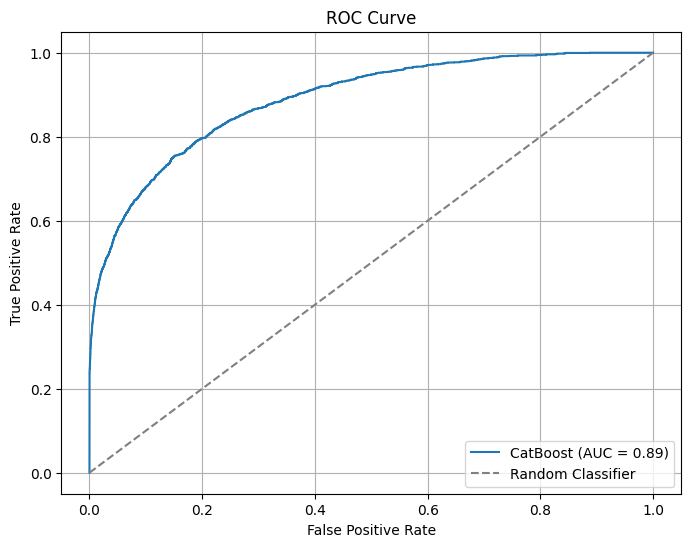

                  Feature Id  Importances
0          transactionAmount    25.041737
1               merchantName    16.543556
2               posEntryMode    15.726886
3       merchantCategoryCode    12.144301
4                 customerId    10.891311
5                cardPresent     8.432262
6            cardLast4Digits     1.999388
7           posConditionCode     1.760128
8        merchantCountryCode     1.119751
9    dateOfLastAddressChange     0.944726
10                 time_diff     0.901193
11            currentBalance     0.891036
12            availableMoney     0.828797
13               creditLimit     0.661738
14           transactionType     0.572114
15           transactionDate     0.492999
16                acqCountry     0.392943
17            mismatched_cvv     0.322254
18       transactionDateTime     0.261171
19        mismatched_country     0.063081
20  expirationDateKeyInMatch     0.008628


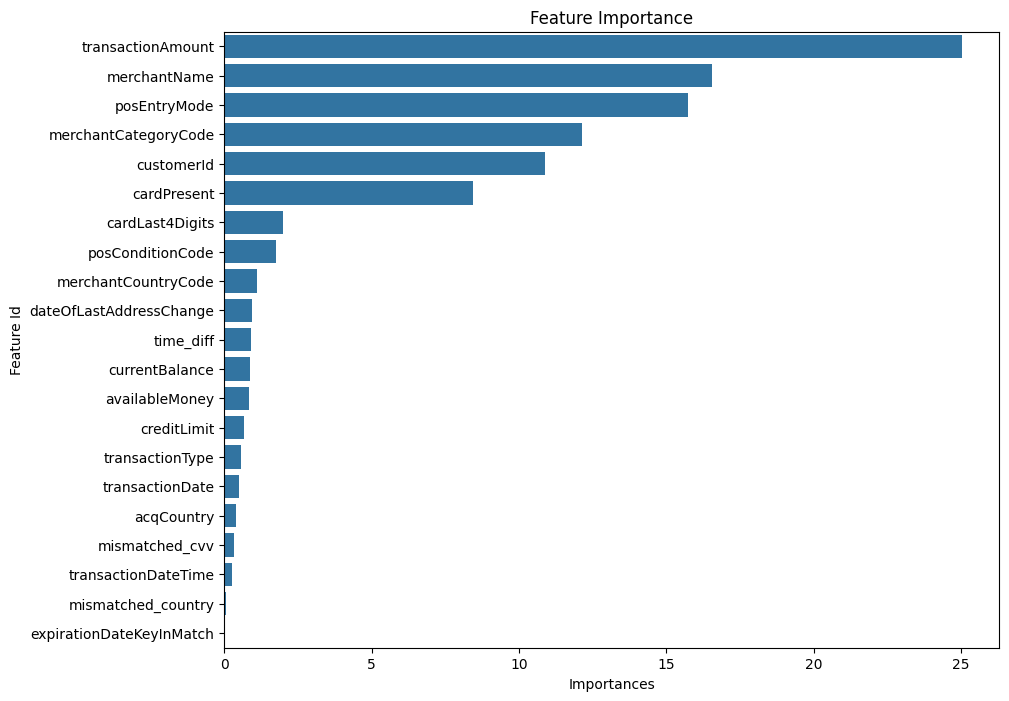

In [21]:
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, accuracy_score

# Evaluate the model using classification report and accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# 2. Calculate the probabilities for the positive class (fraud)
y_prob = model.predict_proba(X_test)[:, 1]  # Getting the probabilities for the positive class (isFraud = 1)

# 3. Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {roc_auc}")

# 4. Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Feature Importance
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['Importances'], y=feature_importances['Feature Id'])
plt.title('Feature Importance')
plt.show()



2. Adjust parameter in catboostclassifier model.

High imbalanced data. The results show high precision low recall for fraud detection.
-> change decision threshold
-> increase weight for fraud ( minority class )

In [36]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, class_weights=[1, 10], random_seed=42)

# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

0:	learn: 0.6191156	test: 0.6185176	best: 0.6185176 (0)	total: 281ms	remaining: 4m 41s
100:	learn: 0.2583804	test: 0.2472821	best: 0.2472821 (100)	total: 22.5s	remaining: 3m 20s
200:	learn: 0.2507254	test: 0.2450605	best: 0.2449752 (194)	total: 45.4s	remaining: 3m
300:	learn: 0.2446711	test: 0.2446458	best: 0.2446049 (277)	total: 1m 9s	remaining: 2m 40s
400:	learn: 0.2393003	test: 0.2444363	best: 0.2444308 (399)	total: 1m 34s	remaining: 2m 21s
500:	learn: 0.2343871	test: 0.2447104	best: 0.2443197 (429)	total: 1m 58s	remaining: 1m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2443196728
bestIteration = 429

Shrink model to first 430 iterations.
Test Accuracy: 0.9779153066847527
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    116111
        True       0.34      0.43      0.38      1844

    accuracy                           0.98    117955
   macro avg       0.66      0.71      0.68    117955
weighted avg   

Precision for fraud dropped from 0.93 to 0.34.
Recall improved from 0.24 to 0.43.

Test Accuracy: 0.9779153066847527
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    116111
        True       0.34      0.43      0.38      1844

    accuracy                           0.98    117955
   macro avg       0.66      0.71      0.68    117955
weighted avg       0.98      0.98      0.98    117955

AUC Score: 0.8887360355734099


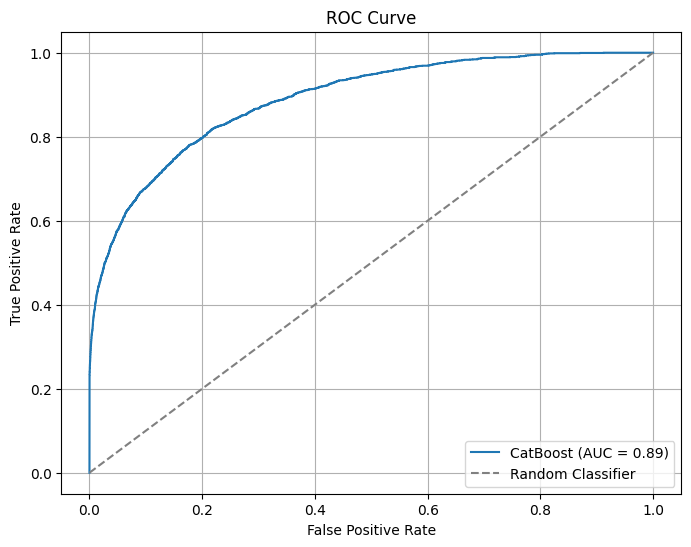

                  Feature Id  Importances
0          transactionAmount    21.271215
1               merchantName    14.601151
2       merchantCategoryCode    13.014182
3               posEntryMode     9.970893
4                 customerId     9.695147
5                cardPresent     6.299325
6                  time_diff     4.462422
7             currentBalance     3.473731
8    dateOfLastAddressChange     2.929631
9             availableMoney     2.590936
10           cardLast4Digits     2.504619
11           transactionDate     1.926813
12       transactionDateTime     1.838155
13               creditLimit     1.723503
14          posConditionCode     1.409194
15       merchantCountryCode     0.556020
16            mismatched_cvv     0.551641
17                acqCountry     0.535703
18           transactionType     0.529215
19        mismatched_country     0.079179
20  expirationDateKeyInMatch     0.037327


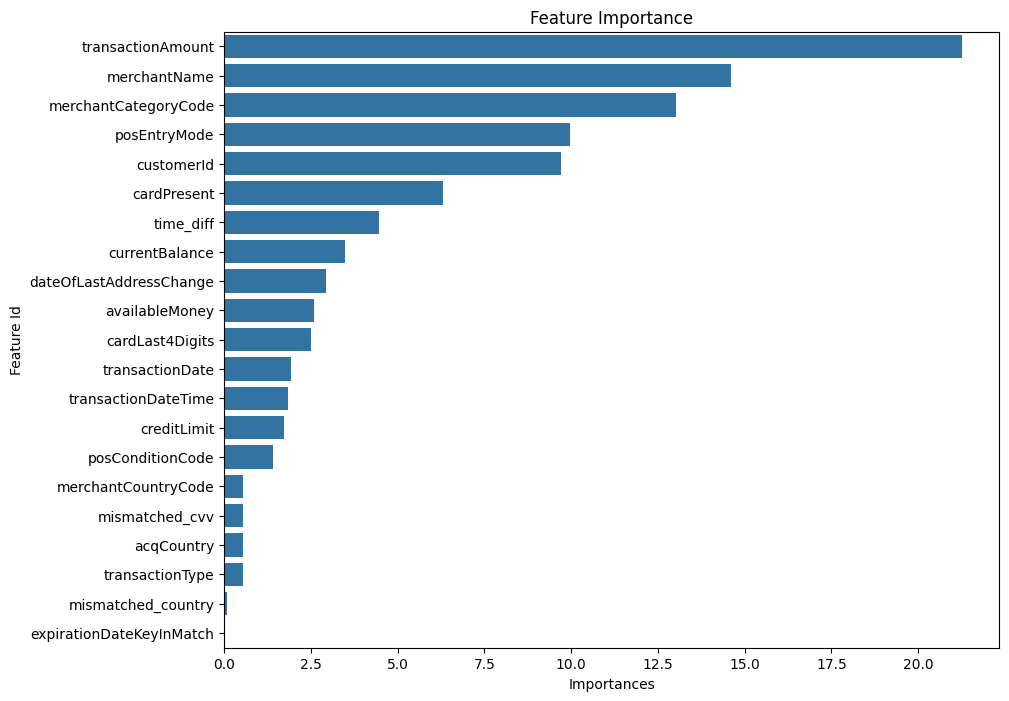

In [38]:
# Evaluate the model using classification report and accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# 2. Calculate the probabilities for the positive class (fraud)
y_prob = model.predict_proba(X_test)[:, 1]  # Getting the probabilities for the positive class (isFraud = 1)

# 3. Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {roc_auc}")

# 4. Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Feature Importance
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['Importances'], y=feature_importances['Feature Id'])
plt.title('Feature Importance')
plt.show()

3. Hyperparameter tuning:

In [24]:
# Define hyperparameter grid
param_grid = {
    'iterations': [300, 500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'class_weights': [[1, 10], [1, 20], [1, 50]],  # Adjust weight for minority class
}


In [25]:
model = CatBoostClassifier(
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

In [ ]:
# from tqdm import tqdm

# class GridSearchWithProgress(GridSearchCV):
#     def fit(self, X, y=None, **fit_params):
#         n_total_fits = len(self.param_grid) * self.cv  # Total number of runs
#         with tqdm(total=n_total_fits, desc="GridSearch Progress") as pbar:
#             for params, _ in self._iter_test_scores():
#                 pbar.update(1)  # Update progress bar for each run
#                 yield params

# grid_search = GridSearchWithProgress(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

In [26]:
from sklearn.model_selection import GridSearchCV

# Grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score for imbalanced datasets
    cv=3,          # 3-fold cross-validation
    n_jobs=-1      # Use all CPU cores
    # verbose=3  # Adjust verbosity level (3 provides detailed updates)
)

# Fit the model
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


0:	learn: 0.8610674	total: 921ms	remaining: 4m 35s
0:	learn: 0.8610883	total: 1.11s	remaining: 5m 31s
0:	learn: 0.8610892	total: 1s	remaining: 4m 59s
0:	learn: 0.8610674	total: 890ms	remaining: 4m 26s
0:	learn: 0.8610883	total: 984ms	remaining: 4m 54s
0:	learn: 0.8610892	total: 866ms	remaining: 4m 18s
0:	learn: 0.8610674	total: 1.08s	remaining: 5m 23s
0:	learn: 0.8610883	total: 918ms	remaining: 4m 34s
100:	learn: 0.8678105	total: 1m 15s	remaining: 2m 28s
100:	learn: 0.8682083	total: 1m 16s	remaining: 2m 29s
100:	learn: 0.8613720	total: 1m 16s	remaining: 2m 31s
100:	learn: 0.8972183	total: 1m 22s	remaining: 2m 43s
100:	learn: 0.8974874	total: 1m 24s	remaining: 2m 47s
100:	learn: 0.8967270	total: 1m 25s	remaining: 2m 48s
100:	learn: 0.9000339	total: 1m 24s	remaining: 2m 46s
100:	learn: 0.8982387	total: 1m 25s	remaining: 2m 48s
200:	learn: 0.8910000	total: 2m 31s	remaining: 1m 14s
200:	learn: 0.8881434	total: 2m 31s	remaining: 1m 14s
200:	learn: 0.8910713	total: 2m 32s	remaining: 1m 14s
2

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0:	learn: 0.8610745	total: 311ms	remaining: 1m 32s
100:	learn: 0.8800345	total: 19.2s	remaining: 37.8s
200:	learn: 0.8961905	total: 39.6s	remaining: 19.5s
299:	learn: 0.8983904	total: 1m	remaining: 0us
Best Parameters: {'class_weights': [1, 10], 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [27]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)


Best Parameters: {'class_weights': [1, 10], 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best F1-Score: 0.391204492542973


In [29]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the model on the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    116111
        True       0.47      0.34      0.40      1844

    accuracy                           0.98    117955
   macro avg       0.73      0.67      0.69    117955
weighted avg       0.98      0.98      0.98    117955

Confusion Matrix:
[[115384    727]
 [  1208    636]]


F1 score is higher with fine tuned parameter. Precision improves however recall drops a little. For fraud detection, prefer higher recall.